In [1]:
import os
os.chdir('/home/soham/Desktop/GitHub/BTP/scripts/Mixture + Analytes/4 Mixtures/')

from utils import add_noise, plot_pca_decision_boundary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re

import warnings
warnings.filterwarnings('ignore')
os.chdir('/home/soham/Desktop/GitHub/BTP/')

In [2]:
total_data = pd.read_csv('data/labelled/labelled.csv')
total_data.head()

,CFU/mL,Sensor2,Sensor1,Sensor3,label
0,30500000.0,70.734,-68.02,52.47,1
1,3050000.0,50.162,-95.70,32.63,1
2,305000.0,-8.390,-99.96,-10.41,1
3,30500.0,-18.700,-107.42,-23.93,1
4,3050.0,-19.620,-109.94,-27.24,1


## PCA

In [3]:
total_data = total_data.drop(['CFU/mL'], axis=1)
labels = total_data['label']

total_data.head()

,Sensor2,Sensor1,Sensor3,label
0,70.734,-68.02,52.47,1
1,50.162,-95.70,32.63,1
2,-8.390,-99.96,-10.41,1
3,-18.700,-107.42,-23.93,1
4,-19.620,-109.94,-27.24,1


In [4]:
X = total_data[['Sensor1','Sensor2','Sensor3']]
Y = total_data['label']
label_mapping = {1: 'A1', 2: 'A2', 3: 'A3'}

pca  = PCA(n_components=2)
pca.fit(X)
pca_data = pca.transform(X)
pca_data = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

X_train, X_test, Y_train, Y_test = train_test_split(pca_data, Y, test_size=0.3, random_state=np.random.randint(0,100))

pca_data.head()

,PC1,PC2
0,-22.442149,55.984647
1,-43.457599,24.248253
2,-31.610782,-43.949584
3,-36.054776,-61.840659
4,-38.263527,-65.442300


### SVM

In [5]:
svm = SVC(kernel='linear')
svm.fit(X_train, Y_train)

print('Training accuracy = ', svm.score(X_train, Y_train))

pred = svm.predict(X_test)
print('Testing accuracy = ', accuracy_score(Y_test, pred))

Training accuracy =  1.0
Testing accuracy =  1.0


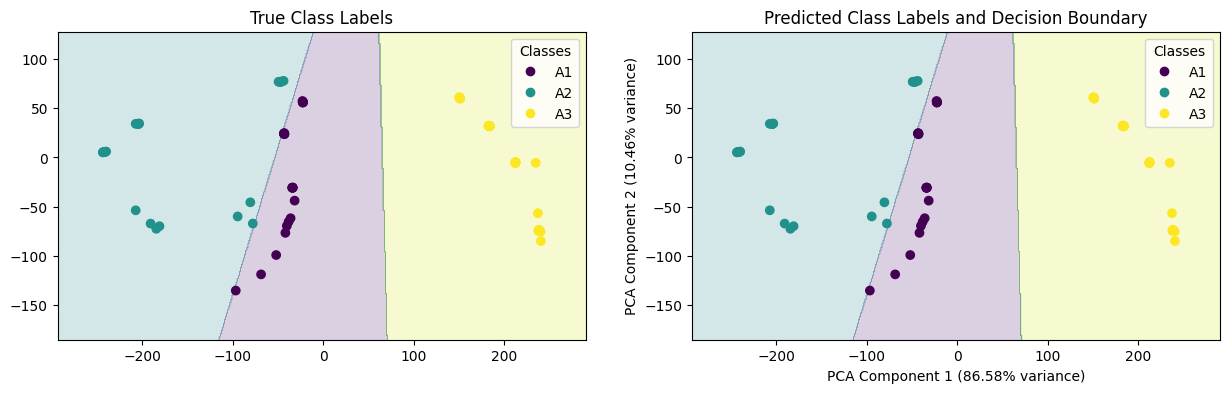

In [6]:
pca_data['Labels'] = total_data['label'].map(label_mapping)
plot_pca_decision_boundary(pca, pca_data, svm, label_mapping)

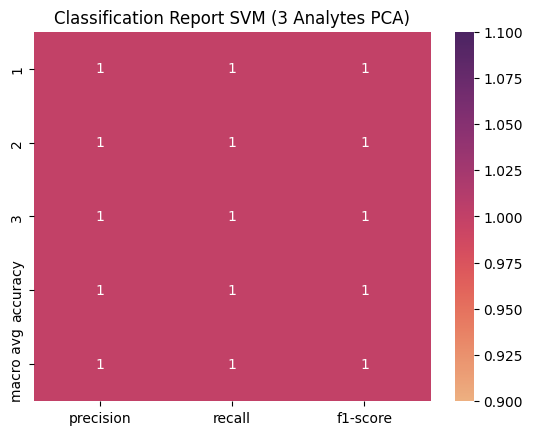

In [7]:
''' Confusion matrix '''

predictions = svm.predict(pca_data[['PC1','PC2']])
report = classification_report(predictions, Y, output_dict=True)
report = pd.DataFrame(report).transpose()

sns.heatmap(report.iloc[:-1, :-1], annot=True, cmap='flare')
plt.title('Classification Report SVM (3 Analytes PCA)')
plt.show()

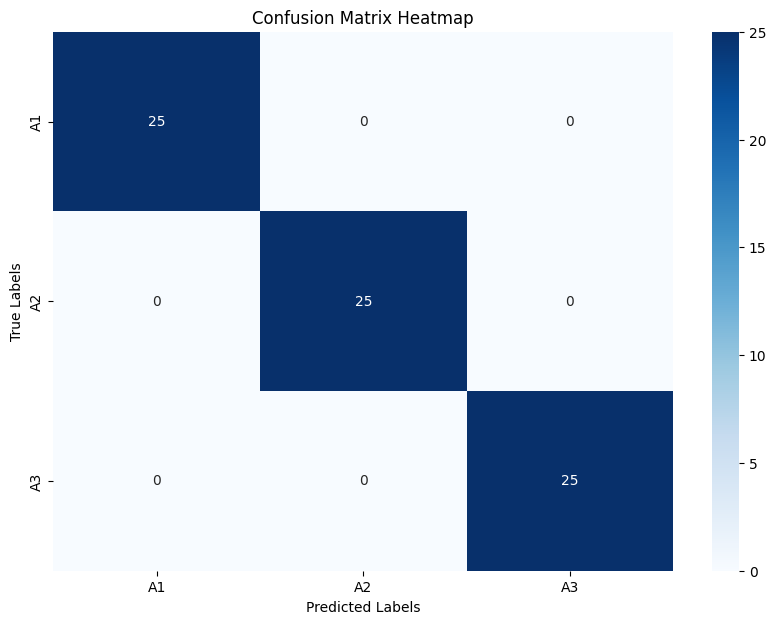

In [8]:
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(Y, predictions)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Adding Additional Points

Noise Level: 0.05
Accuracy: 0.9866666666666667


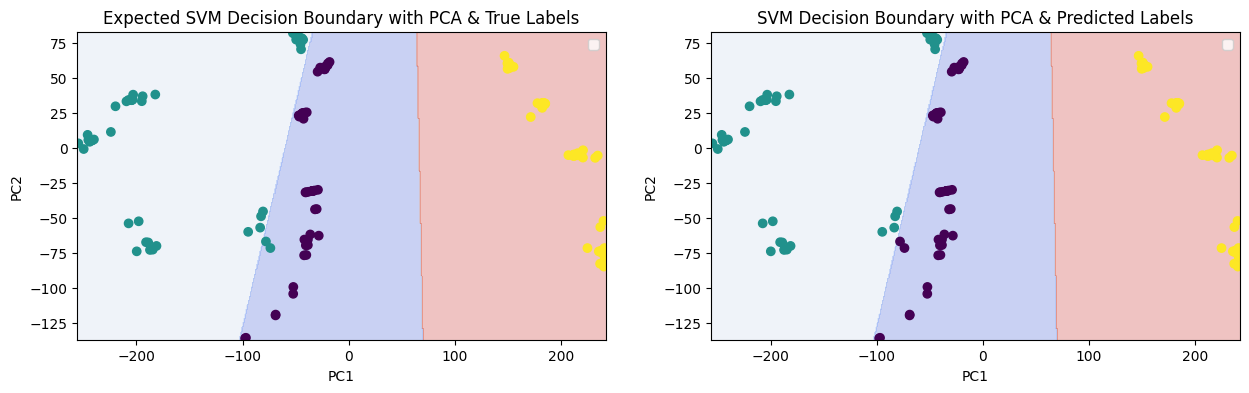

Noise Level: 0.1
Accuracy: 0.9666666666666667


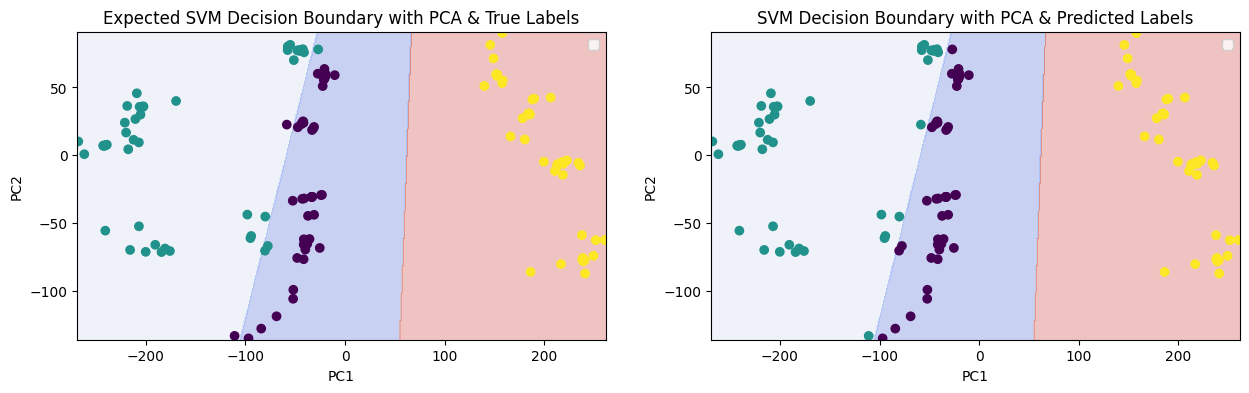

Noise Level: 0.15
Accuracy: 0.9666666666666667


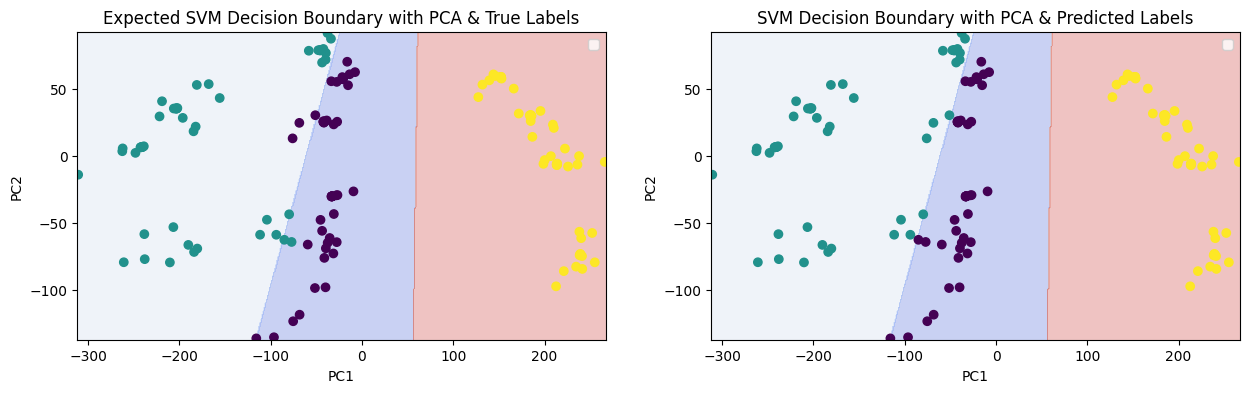

In [8]:
for p in [0.05, 0.10, 0.15]:

    data_noisy = total_data.copy()

    for i in range(3):
        data_noisy[['Sensor1', 'Sensor2', 'Sensor3']] = add_noise(total_data[['Sensor1', 'Sensor2', 'Sensor3']], p)
        data_augmented = pd.concat([total_data, data_noisy], axis=0).reset_index(drop=True)

    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data_augmented[['Sensor1','Sensor2','Sensor3']])
    pca_data = pd.DataFrame(pca_data, columns=['PC1','PC2'])
    pca_data['Label'] = data_augmented['label']


    svc = SVC(kernel='linear')
    svc.fit(pca_data[['PC1','PC2']], pca_data['Label'])

    x_min, x_max = pca_data['PC1'].min() - 1, pca_data['PC1'].max() + 1
    y_min, y_max = pca_data['PC2'].min() - 1, pca_data['PC2'].max() + 1
    X, Y = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    Z = svc.predict(np.c_[X.ravel(), Y.ravel()])
    Z = Z.reshape(X.shape)


    # PLOTTING THE DECISION BOUNDARY 

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ax[0].contourf(X, Y, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax[0].scatter(pca_data['PC1'], pca_data['PC2'], c=pca_data['Label'], marker='o')
    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    ax[0].set_title('Expected SVM Decision Boundary with PCA & True Labels')
    ax[0].legend()

    predicted_labels = svc.predict(pca_data[['PC1', 'PC2']])

    ax[1].contourf(X, Y, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax[1].scatter(pca_data['PC1'], pca_data['PC2'], c=predicted_labels, marker='o')
    ax[1].set_xlabel('PC1')
    ax[1].set_ylabel('PC2')
    ax[1].set_title('SVM Decision Boundary with PCA & Predicted Labels')
    ax[1].legend()

    fig.savefig('docs/plots/svm/svm_on_raw.png')

    print(f'Noise Level: {p}')
    print(f'Accuracy: {np.mean(pca_data["Label"] == predicted_labels)}')
    plt.show()